In [11]:
#### ------------------------------------------------------------------------------------------
#### author: Ranjan Barman, date: June 22, 2025
#### Compute 12NPIFs based on HoverNet prediction, using MPP = 0.248 for unit conversion
#### Removes outliers for Major Axis and Minor Axis using IQR
#### Filters top 25% tiles based on majority of cancer nuclei
#### Dataset: POST_NAT_BRCA
#### ------------------------------------------------------------------------------------------

import os
import pandas as pd
import numpy as np

# Set working directory
_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.makedirs(_wpath_, exist_ok=True)
os.chdir(_wpath_)

print("Working directory:", _wpath_)

# Define dataset name and output file path dynamically
dataset_name = "POST_NAT_BRCA"
input_folder = f"{dataset_name}/HoverNet/outputs/"
output_file_path = f"{dataset_name}/HoverNet/outputs/POST_NAT_BRCA_HoverNet_NPIFs_Filtered_Tiles_Top25Q.csv"

# Define column names for computation
columns_to_compute = ["Area", "Major Axis", "Minor Axis", "Perimeter", "Eccentricity", "Circularity"]

# Define MPP for conversion
MPP = 0.248

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Store results in a list
results = []

# Get all folders matching POST_NAT pattern
slide_folders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f)) and f.endswith("_tiles")]

# Process each detected slide
for slide_name in slide_folders:
    file_path = os.path.join(input_folder, slide_name, "features", f"{slide_name}.csv")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}, skipping...")
        continue

    df = pd.read_csv(file_path)

    # Convert units using MPP
    df["Area"] = df["Area"] * (MPP ** 2)
    df["Major Axis"] = df["Major Axis"] * MPP
    df["Minor Axis"] = df["Minor Axis"] * MPP
    df["Perimeter"] = df["Perimeter"] * MPP

    # Remove outliers for Major Axis and Minor Axis
    df = remove_outliers(df, "Major Axis")
    df = remove_outliers(df, "Minor Axis")

    # Count total nuclei per tile
    tile_nucleus_counts = df.groupby("Tile")["Nucleus ID"].count().reset_index()
    tile_nucleus_counts.rename(columns={"Nucleus ID": "Nucleus_Count"}, inplace=True)

    # Get total number of tiles with cancer nuclei
    total_tiles_with_nuclei = tile_nucleus_counts.shape[0]

    # Compute 75th percentile threshold
    percentile_75 = tile_nucleus_counts["Nucleus_Count"].quantile(0.75)

    # Filter top 25% tiles
    top_25_percent_tiles = tile_nucleus_counts[tile_nucleus_counts["Nucleus_Count"] >= percentile_75]
    num_filtered_tiles = top_25_percent_tiles.shape[0]

    print(f"Slide: {slide_name}")
    print(f"  - Total tiles with cancer nuclei: {total_tiles_with_nuclei}")
    print(f"  - 75th percentile nucleus count threshold: {percentile_75}")
    print(f"  - Number of tiles selected (top 25%): {num_filtered_tiles}")

    # Filter dataframe
    df_filtered = df[df["Tile"].isin(top_25_percent_tiles["Tile"])]
    if df_filtered.empty:
        print(f"  - No tiles with nucleus count in top 25% for {slide_name}, skipping...\n")
        continue

    # Compute statistics
    mean_values = df_filtered[columns_to_compute].mean()
    std_values = df_filtered[columns_to_compute].std()

    # Append result row
    results.append([slide_name, total_tiles_with_nuclei, num_filtered_tiles] + mean_values.tolist() + std_values.tolist())

# Convert result list to DataFrame
result_df = pd.DataFrame(
    results,
    columns=["Slide_Name", "Total_Tiles", "Filtered_Tiles"] + 
            [f"Mean {col}" for col in columns_to_compute] + 
            [f"Std {col}" for col in columns_to_compute]
)

# Handle NaN/infs
result_df.replace([np.inf, -np.inf], np.nan, inplace=True)
result_df.fillna(result_df.mean(numeric_only=True), inplace=True)
result_df.fillna(0, inplace=True)

result_df

# Save slide-level results
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
result_df.to_csv(output_file_path, index=False)
print(f"\nFiltered results saved to: {output_file_path}")


Working directory: /data/Lab_ruppin/Ranjan/HnE/
Slide: 99798_2068_tiles
  - Total tiles with cancer nuclei: 1799
  - 75th percentile nucleus count threshold: 78.0
  - Number of tiles selected (top 25%): 455
Slide: 102194_3173_tiles
  - Total tiles with cancer nuclei: 1932
  - 75th percentile nucleus count threshold: 32.0
  - Number of tiles selected (top 25%): 486
Slide: 102195_2284_tiles
  - Total tiles with cancer nuclei: 1707
  - 75th percentile nucleus count threshold: 69.0
  - Number of tiles selected (top 25%): 429
Slide: 99795_3386_tiles
  - Total tiles with cancer nuclei: 2957
  - 75th percentile nucleus count threshold: 138.0
  - Number of tiles selected (top 25%): 742
Slide: 99810_2730_tiles
  - Total tiles with cancer nuclei: 1929
  - 75th percentile nucleus count threshold: 7.0
  - Number of tiles selected (top 25%): 542
Slide: 102184_1621_tiles
  - Total tiles with cancer nuclei: 1158
  - 75th percentile nucleus count threshold: 98.0
  - Number of tiles selected (top 25%):

In [12]:
result_df

,Slide_Name,Total_Tiles,Filtered_Tiles,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
0,99798_2068_tiles,1799,455,12.110002,4.872378,3.292186,13.738033,0.687528,0.758887,6.749821,1.459810,0.912796,3.831462,0.151185,0.094628
1,102194_3173_tiles,1932,486,10.388229,4.480932,3.056997,12.708943,0.683791,0.760593,6.085628,1.346381,0.893103,3.675057,0.149865,0.095985
2,102195_2284_tiles,1707,429,10.063186,4.441220,3.006680,12.541696,0.689261,0.761891,5.731067,1.271643,0.847109,3.445331,0.150683,0.094641
3,99795_3386_tiles,2957,742,10.931569,4.537686,3.223211,13.114491,0.649544,0.762035,5.408721,1.226125,0.820293,3.279427,0.162747,0.100397
4,99810_2730_tiles,1929,542,12.246139,5.003242,3.279325,14.140610,0.708653,0.729628,7.306547,1.551476,0.973147,4.235605,0.147094,0.108782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,102197_1224_tiles,977,247,12.025758,4.760359,3.397544,13.696787,0.652386,0.773834,5.616060,1.236520,0.787010,3.301406,0.150443,0.088209
92,102198_885_tiles,620,163,10.667405,4.703940,3.055917,13.217265,0.710147,0.731216,6.212884,1.475131,0.865379,3.921383,0.147277,0.104294
93,99861_4107_tiles,2950,765,11.110142,4.673790,3.151681,13.222728,0.693322,0.750300,6.697931,1.423374,0.947824,3.891743,0.147842,0.097553
94,99809_4161_tiles,3236,864,11.352474,4.848345,3.165029,13.656520,0.711400,0.731122,6.356277,1.434029,0.898016,3.896433,0.146830,0.107213


In [13]:
# Extract Slide_ID as the part before the first underscore in Slide_Name
result_df['Slide_ID'] = result_df['Slide_Name'].str.split('_').str[0]
result_df

# Aggregate patient-level features
patient_avg_df = result_df.groupby('Slide_ID').mean(numeric_only=True)

patient_avg_df

# Save patient-level results
patient_avg_df.to_csv(output_file_path)
print(f"Converted results saved to: {output_file_path}")

patient_avg_df


Converted results saved to: POST_NAT_BRCA/HoverNet/outputs/POST_NAT_BRCA_HoverNet_NPIFs_Filtered_Tiles_Top25Q.csv


,Total_Tiles,Filtered_Tiles,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
Slide_ID,,,,,,,,,,,,,,
102174,2525,637,9.430833,4.350722,2.917790,12.275448,0.688467,0.757201,4.838805,1.279108,0.714565,3.312431,0.150907,0.098028
102175,1011,256,10.895589,4.617728,3.177557,13.113854,0.680553,0.766479,4.919339,1.155851,0.749577,3.078673,0.147486,0.088327
102176,1085,273,9.839813,4.421924,3.010468,12.546902,0.686441,0.759704,4.377247,1.118213,0.704169,2.968074,0.147640,0.093032
102177,1316,329,11.674063,4.756072,3.311253,13.657252,0.671559,0.756007,5.462007,1.238756,0.794563,3.330205,0.148827,0.090623
102178,930,235,11.986304,4.911012,3.242420,13.670667,0.700530,0.761745,6.384184,1.460795,0.871986,3.734849,0.150244,0.092531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99861,2950,765,11.110142,4.673790,3.151681,13.222728,0.693322,0.750300,6.697931,1.423374,0.947824,3.891743,0.147842,0.097553
99862,1680,428,9.897942,4.451017,3.023338,12.661316,0.688391,0.752899,4.366294,1.121532,0.704138,3.022307,0.146829,0.095731
99866,1194,301,9.945432,4.252676,3.161683,12.507906,0.621358,0.774764,3.946507,0.942833,0.656312,2.563861,0.155146,0.096037


In [14]:
patient_avg_df.describe()

,Total_Tiles,Filtered_Tiles,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
count,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1871.34375,478.416667,11.369520,4.711836,3.208505,13.432466,0.683258,0.748022,6.176887,1.362319,0.869218,3.704402,0.150396,0.099970
std,759.15529,194.879972,1.972286,0.364291,0.258362,1.008153,0.024110,0.017031,1.923507,0.241908,0.182080,0.692048,0.003976,0.008497
min,496.00000,125.000000,7.877137,4.067837,2.662539,11.559711,0.561908,0.699202,3.096055,0.680272,0.553796,1.959135,0.143442,0.074413
25%,1206.75000,311.750000,9.970737,4.441143,3.026026,12.650017,0.674210,0.737088,4.755364,1.211907,0.735846,3.295785,0.147612,0.094638
50%,1754.00000,452.000000,10.986780,4.640137,3.179556,13.219048,0.688429,0.749131,5.791498,1.328323,0.850080,3.578348,0.149739,0.099371
75%,2290.25000,600.500000,12.292428,4.906453,3.354861,14.033311,0.698599,0.760674,6.732662,1.464379,0.945469,3.947021,0.152463,0.104162
max,4074.00000,1098.000000,17.332928,5.796877,3.833585,16.354091,0.728440,0.802249,12.884810,2.107574,1.424608,5.766509,0.163667,0.140306


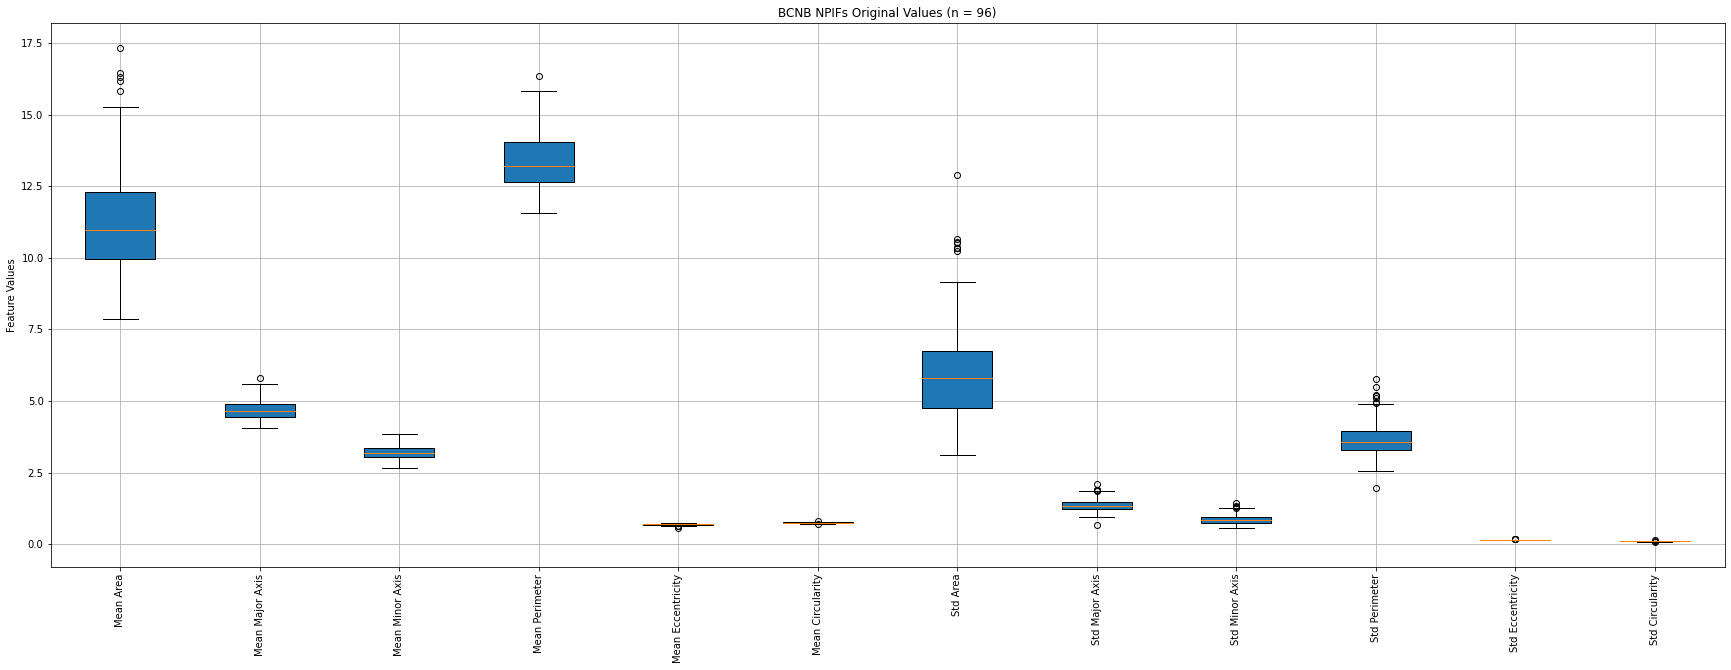

In [15]:
# Plotting
import matplotlib.pyplot as plt

# Select only NPIF features
bcnp_features = patient_avg_df.iloc[:, 2:]
n_bcnp = bcnp_features.shape[0]

# Boxplot
plt.figure(figsize=(30, 10))
plt.boxplot(bcnp_features.values, labels=bcnp_features.columns, vert=True, patch_artist=True)
plt.xticks(rotation=90)
plt.title(f"BCNB NPIFs Original Values (n = {n_bcnp})")
plt.ylabel("Feature Values")
plt.grid(True)
plt.show()